In [ ]:
! pip install covid19dh

In [ ]:
from covid19dh import covid19
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import scipy as sp
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
covid_df, covid_src = covid19()

We have invested a lot of time and effort in creating COVID-19 Data Hub, please cite the following when using it:

	Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.

A BibTeX entry for LaTeX users is

	@Article{,
		title = {COVID-19 Data Hub},
		year = {2020},
		doi = {10.21105/joss.02376},
		author = {Emanuele Guidotti and David Ardia},
		journal = {Journal of Open Source Software},
		volume = {5},
		number = {51},
		pages = {2376},
	}

To hide this message use 'verbose = False'.


Liczba wartości brakujących dla każdej zmiennej: 
id                                        0
date                                      0
confirmed                                 0
deaths                                    0
recovered                                 0
tests                                     0
vaccines                                519
people_vaccinated                       519
people_fully_vaccinated                 519
hosp                                      0
icu                                       0
vent                                   1557
school_closing                          515
workplace_closing                       515
cancel_events                           515
gatherings_restrictions                 515
transport_closing                       515
stay_home_restrictions                  515
internal_movement_restrictions          515
international_movement_restrictions     515
information_campaigns                   515
testing_policy            

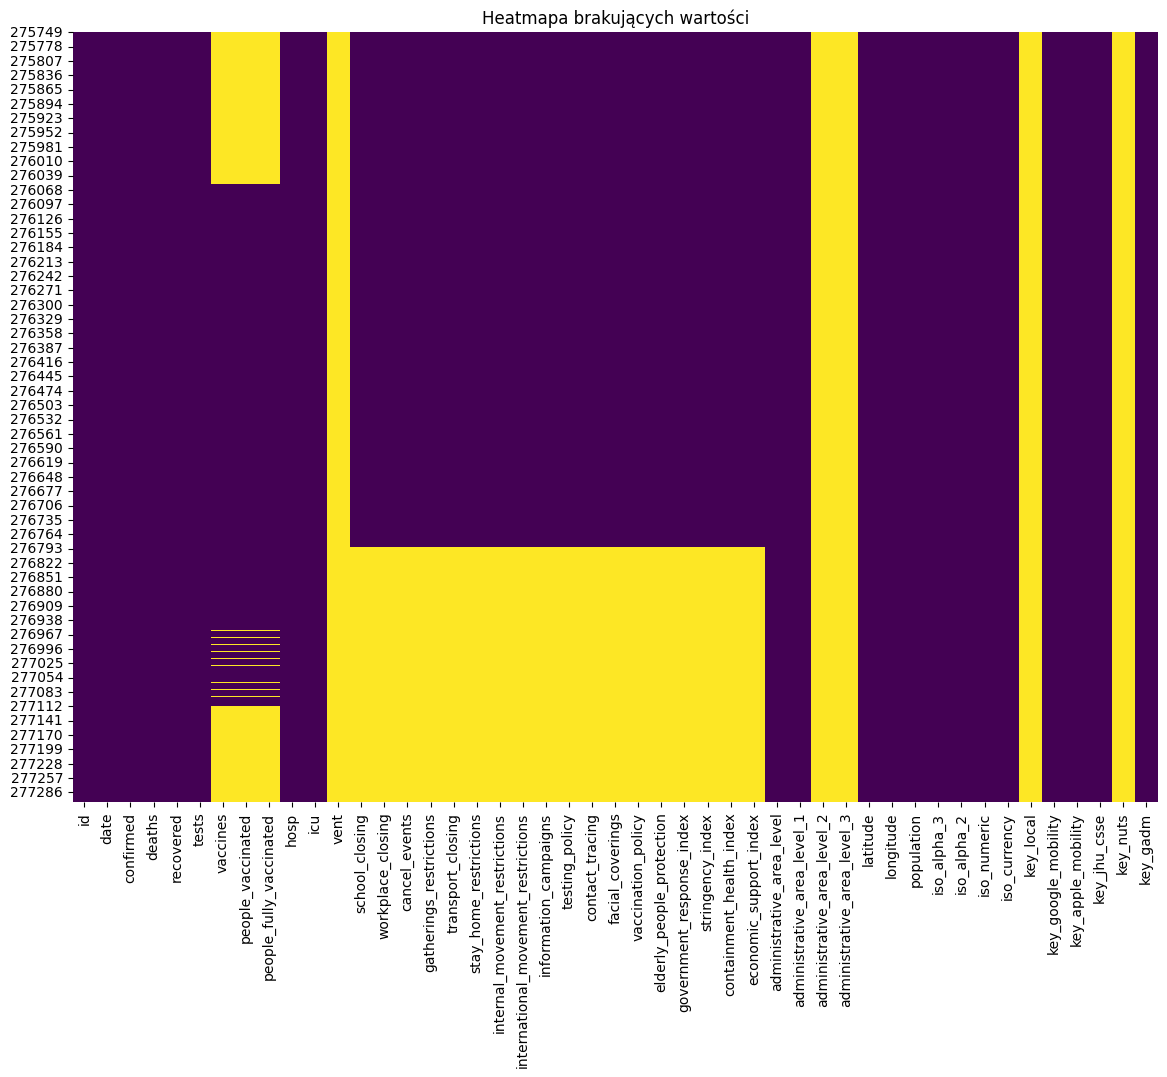

In [ ]:
covid_df_italy = covid_df[covid_df['administrative_area_level_1'] == 'Italy']
missing_values_italy = covid_df_italy.isnull().sum()

print(f'Liczba wartości brakujących dla każdej zmiennej: \n{missing_values_italy}')

plt.figure(figsize=(14, 10))

sns.heatmap(covid_df_italy.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmapa brakujących wartości')
plt.show()

Włochy posiadają w swoich raportach realatywnie mało braujących danych. Co najważniejsze nie mają brakujących danych dla liczby przypadków oraz liczby śmierci. Posiadają brakujące wartości dotyczące szczepień na początku pandemii (co jest logiczne) i na końcu. Posiadają też brakujące dane dla działań politycznych - około 1/3 obserwacji i wszystko znajduje się pod koniec pandemii i może być to spowodowane mniejszą dokładnością raportowania gdy pandemia wygasała. Pozostałe brakujące dane nie wydają się kluczowe dla przeprowadzenia algorytmu uczenia maszynowego, więc zostały pominięte.

In [ ]:
covid_df_italy = covid_df_italy.drop(columns=['iso_alpha_3', 'iso_alpha_2', 'iso_numeric', 'iso_currency', 'key_local', 'key_google_mobility', 'key_apple_mobility', 'key_jhu_csse', 'key_nuts', 'key_gadm',
                             'administrative_area_level', 'administrative_area_level_1', 'administrative_area_level_2', 'administrative_area_level_3', 'latitude', 'longitude'])

Usunięto dane dotyczące obszarów administracyjnych, współrzędnych, kodów ISO, kluczy zewnętrznych oraz populacji, gdzyż stwierdzono, że nie potrzeba dogłębnej analizy by uznać je za zbędnę, a usunięcię ich ułatwi dalszą analizę.

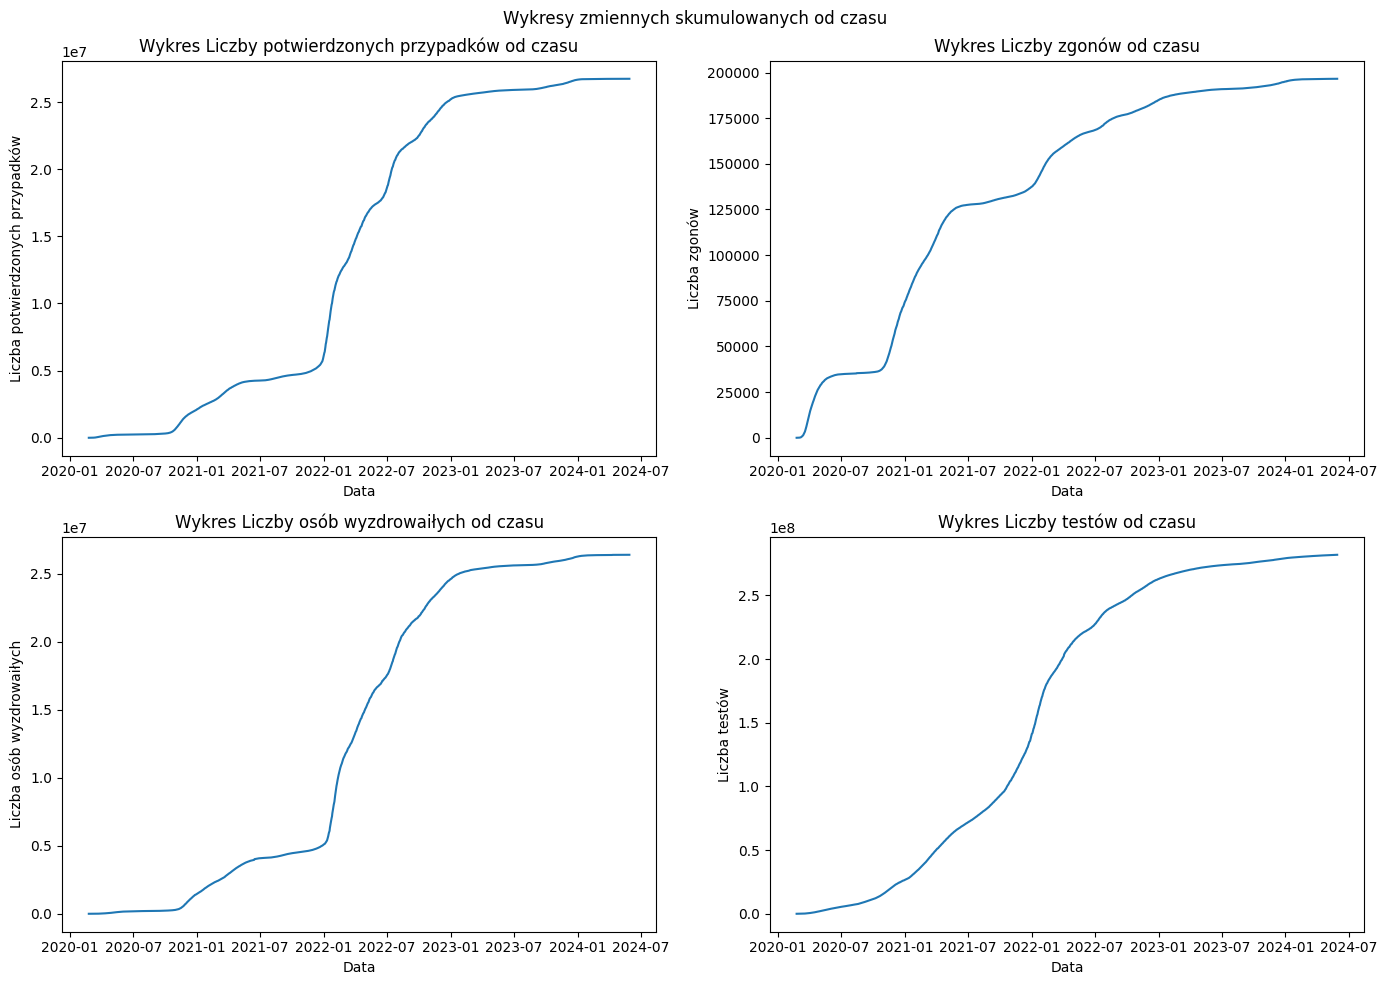

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

fig.suptitle('Wykresy zmiennych skumulowanych od czasu')

sns.lineplot(data=covid_df_italy, x='date', y='confirmed', ax=ax[0][0])
sns.lineplot(data=covid_df_italy, x='date', y='deaths', ax=ax[0][1])
sns.lineplot(data=covid_df_italy, x='date', y='recovered', ax=ax[1][0])
sns.lineplot(data=covid_df_italy, x='date', y='tests', ax=ax[1][1])

ax[0][0].set_title('Wykres Liczby potwierdzonych przypadków od czasu')
ax[0][0].set_ylabel('Liczba potwierdzonych przypadków')
ax[0][0].set_xlabel('Data')

ax[0][1].set_title('Wykres Liczby zgonów od czasu')
ax[0][1].set_ylabel('Liczba zgonów')
ax[0][1].set_xlabel('Data')

ax[1][0].set_title('Wykres Liczby osób wyzdrowaiłych od czasu')
ax[1][0].set_ylabel('Liczba osób wyzdrowaiłych')
ax[1][0].set_xlabel('Data')

ax[1][1].set_title('Wykres Liczby testów od czasu')
ax[1][1].set_ylabel('Liczba testów')
ax[1][1].set_xlabel('Data')


plt.tight_layout()
plt.show()

Wykresy liczby przypadków, zgonów, osób wyzdrowiałych oraz testów, nie są liniowe dla Włoch. Jednak jest to logiczne, poniewż jak wiadomo pandemia w różnych etapach miała rózną siłę, stąd nagłe wzrosty w poszczególnych okresach. Co najważniejsze (ponieważ te zmienne wydają się być dosyć istotne) dane są ciągłe. Przydatne w dalszym etapie wydaję się być rozbicie wartości skumulowanych na przypadki dzienne.

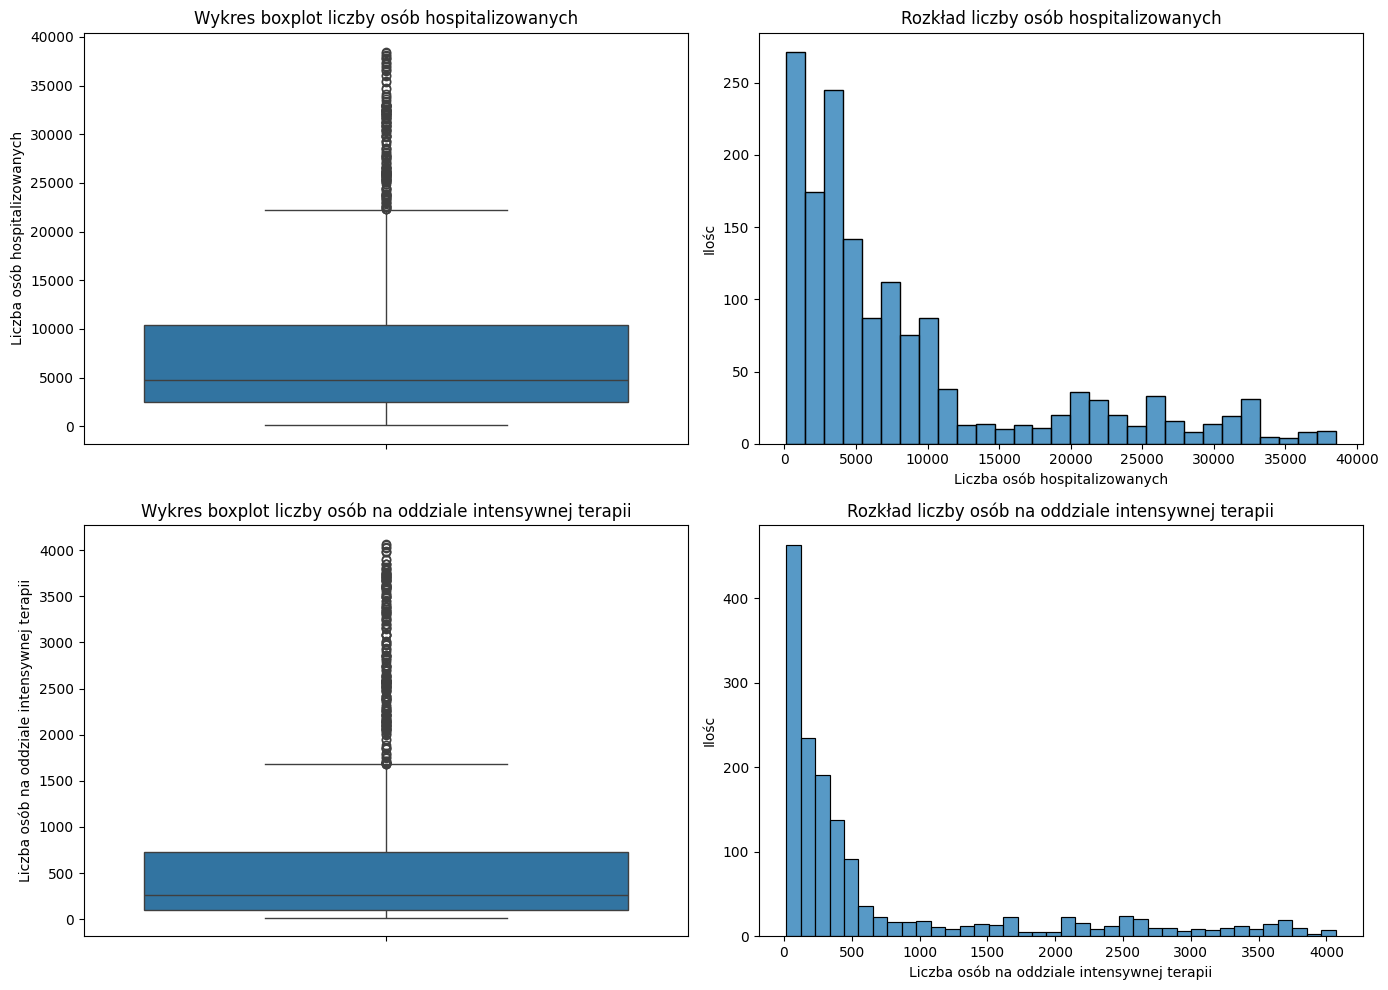

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

sns.boxplot(data=covid_df_italy, y='hosp', ax=ax[0][0])
ax[0][0].set_title('Wykres boxplot liczby osób hospitalizowanych')
ax[0][0].set_ylabel('Liczba osób hospitalizowanych')
sns.histplot(data=covid_df_italy, x='hosp', ax=ax[0][1])
ax[0][1].set_title('Rozkład liczby osób hospitalizowanych')
ax[0][1].set_ylabel('Ilośc')
ax[0][1].set_xlabel('Liczba osób hospitalizowanych')
sns.boxplot(data=covid_df_italy, y='icu', ax=ax[1][0])
ax[1][0].set_title('Wykres boxplot liczby osób na oddziale intensywnej terapii')
ax[1][0].set_ylabel('Liczba osób na oddziale intensywnej terapii')
sns.histplot(data=covid_df_italy, x='icu', ax=ax[1][1])
ax[1][1].set_title('Rozkład liczby osób na oddziale intensywnej terapii')
ax[1][1].set_xlabel('Liczba osób na oddziale intensywnej terapii')
ax[1][1].set_ylabel('Ilośc')

plt.tight_layout()
plt.show()

Histogramy dla ilości osób hospitalizowanych oraz na odziale intensywnej terapii nie są równomierne, co pokazują też wykresy boxplot na których widać dużo wartości odstających. Te wartości mogą wnieść jednak cenne informacje do modelu.

Po wstępnej analizie stwierdzono, że Włochy będą dobrym krajem do przeprowadzenia predykcji liczby zachorowań na Covid-19 i śmierci spowodowanych tym wirusem. Decyzję tą uargumentowano małą liczbą danych brakujących, ciągłością danych oraz dobrym raportowaniem informacji dotyczących pandemii przez ten kraj. Jak wiadomo z informacji kraj ten na początku pandemii borykał się z dużym problemami z tym wirusem i w późniejszym czasie podjął kroki aby zapobiec takim wydarzeniom w przyszłości.

In [ ]:
covid_df_italy = covid_df_italy.drop(columns=['id', 'vent'])

Pozbyto się kolumny `id` zawierającej informację o unikalnym identyfikatorze jednostki geograficznej gdyż stwierdzono, że nie wnosi ona istotnej informacji oraz kolumny `vent` zawierającej informację o liczbie pacjentów wymagających inwazyjnej wentylacji na dzień, ponieważ posiadała ona tylko wartości brakujące.

In [ ]:
covid_df_italy[['vaccines', 'people_vaccinated', 'people_fully_vaccinated']] = covid_df_italy[['vaccines', 'people_vaccinated', 'people_fully_vaccinated']].fillna(method='ffill').fillna(0)



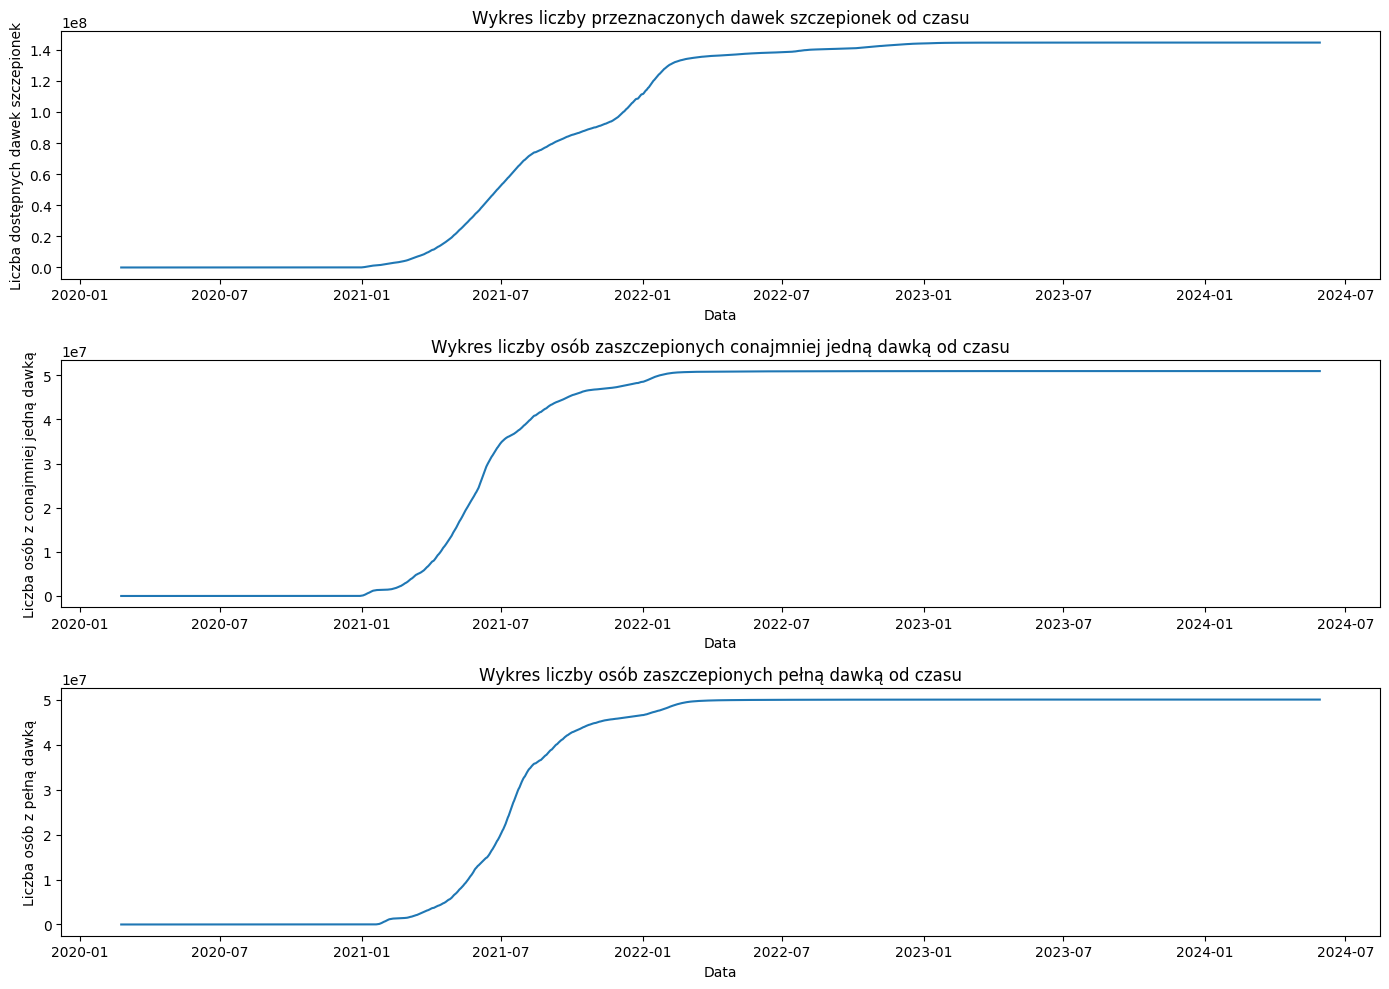

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(14, 10))

sns.lineplot(data=covid_df_italy, x='date', y='vaccines', ax=ax[0])
ax[0].set_title('Wykres liczby przeznaczonych dawek szczepionek od czasu')
ax[0].set_ylabel('Liczba dostępnych dawek szczepionek')
ax[0].set_xlabel('Data')
sns.lineplot(data=covid_df_italy, x='date', y='people_vaccinated', ax=ax[1])
ax[1].set_title('Wykres liczby osób zaszczepionych conajmniej jedną dawką od czasu')
ax[1].set_ylabel('Liczba osób z conajmniej jedną dawką')
ax[1].set_xlabel('Data')
sns.lineplot(data=covid_df_italy, x='date', y='people_fully_vaccinated', ax=ax[2])
ax[2].set_title('Wykres liczby osób zaszczepionych pełną dawką od czasu')
ax[2].set_ylabel('Liczba osób z pełną dawką')
ax[2].set_xlabel('Data')

plt.tight_layout()
plt.show()

Dla danych dotyczących szczepień (liczba podanych dawek, liczba ludzi którzy otrzymali conjamniej jedną dawkę, liczbą ludzi którzy otrzymali pełną dawkę) stwierdzono, że najlepszym podjeściem będzie wypełnienie brakujących wartości używjąc ostatnich dostępnych  wartości, a wartości na początku uzupełnić zerami jako, że są to dane skumulowane. Warte zauważenia jest to że te dane już wcześniej ulegały stagnacji (porównanie z heatmapą wartości brakujących). I dla liczby osób zaszczepionych istotny jest tak naprawdę fragment od początku roku 2021 do początku roku 2022.

> Dodaj cytat blokowy



[1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042]


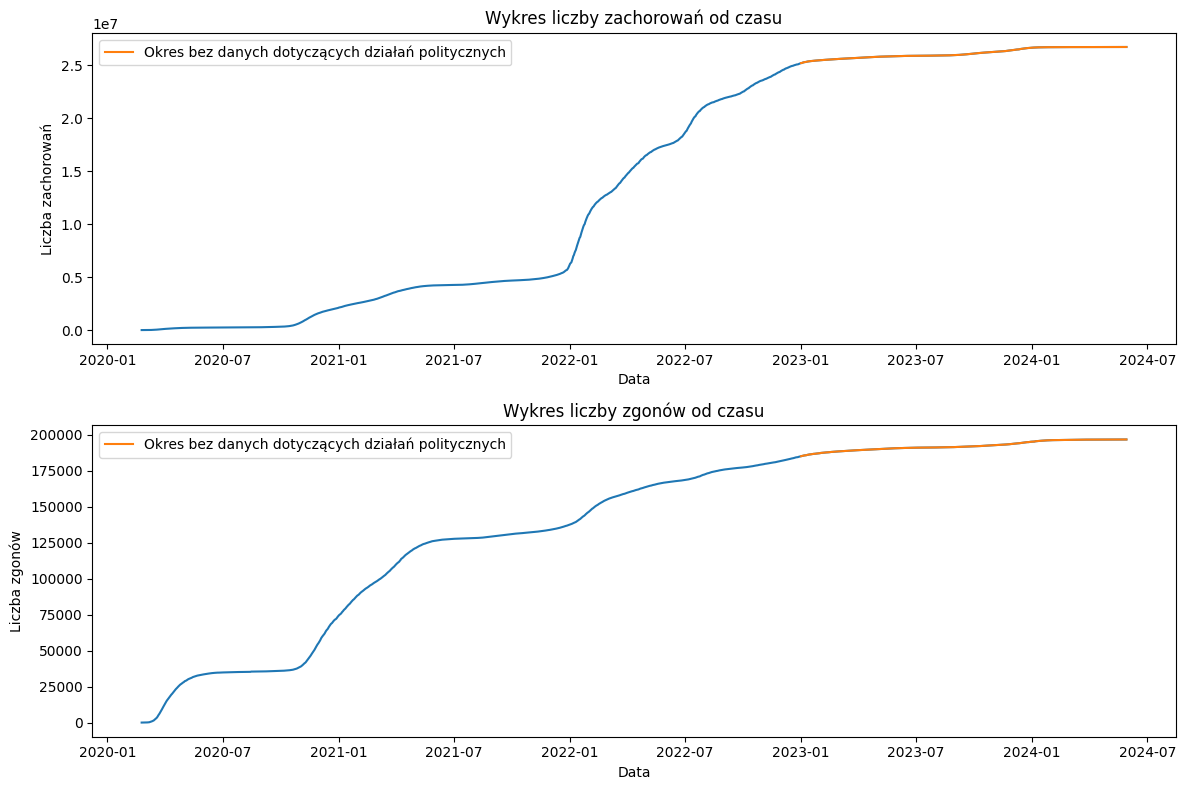

In [ ]:
first_nan_ids = []
covid_df_italy = covid_df_italy.reset_index(drop=True)
administrative_areas_columns = ['school_closing', 'workplace_closing', 'cancel_events', 'gatherings_restrictions', 'transport_closing', 'stay_home_restrictions', 'internal_movement_restrictions',
                                'international_movement_restrictions', 'information_campaigns', 'testing_policy', 'contact_tracing', 'facial_coverings', 'vaccination_policy', 'elderly_people_protection',
                                'government_response_index', 'stringency_index', 'containment_health_index', 'economic_support_index']
# covid_df_italy = covid_df_italy.reset_index(drop=True)
for col in administrative_areas_columns:
  first_nan_id = (covid_df_italy[col].isna() | covid_df_italy[col].isnull()).idxmax()
  first_nan_ids.append(first_nan_id)

print(first_nan_ids)
administrative_areas_id = min(first_nan_ids)

covid_df_italy_ad = covid_df_italy.iloc[administrative_areas_id:]

fig, ax = plt.subplots(2, 1, figsize=(12, 8))

sns.lineplot(data=covid_df_italy, x='date', y='confirmed', ax=ax[0])
sns.lineplot(data=covid_df_italy_ad, x='date', y='confirmed', ax=ax[0], label='Okres bez danych dotyczących działań politycznych')
ax[0].set_title('Wykres liczby zachorowań od czasu')
ax[0].set_xlabel('Data')
ax[0].set_ylabel('Liczba zachorowań')
sns.lineplot(data=covid_df_italy, x='date', y='deaths', ax=ax[1])
sns.lineplot(data=covid_df_italy_ad, x='date', y='deaths', ax=ax[1], label='Okres bez danych dotyczących działań politycznych')
ax[1].set_title('Wykres liczby zgonów od czasu')
ax[1].set_xlabel('Data')
ax[1].set_ylabel('Liczba zgonów')

plt.tight_layout()
plt.show()

Dane dotyczące działań politycznych mających na celu ograniczenie rozprzestrzeniania się pandemii przyjmują brakujące wartości w dokładnie tym samym momencie. Na wykresie widać, że w okresie tym liczba zachorowań oraz zgonów ustabilizowała się co świadczy o wygaszaniu się pandemii wirusa. Z informacji prasowych wynika też, że od tego okresu restrykcje były już zniesione co sugerować może, że nie było to już raportowane. Zdecydowano się więc na usunięcie tych rekordów ze zbioru danych, ze względu na łagodniejszy charaketer przebiegu pandemii (można też powiedzieć zakonćzeniu pandemii) w tym okresie.

In [ ]:
covid_df_italy = covid_df_italy[:administrative_areas_id]

In [ ]:
cumulative_columns = ['confirmed', 'deaths', 'recovered', 'tests', 'vaccines', 'people_vaccinated', 'people_fully_vaccinated']

for col in cumulative_columns:
  covid_df_italy[f'{col}_lag'] = covid_df_italy[col].shift(1).fillna(0)
  covid_df_italy[f'daily_{col}'] = covid_df_italy[col] - covid_df_italy[f'{col}_lag']
  covid_df_italy = covid_df_italy.drop(columns=[f'{col}_lag', col])


<ipython-input-13-3e7160180b96>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_df_italy[f'{col}_lag'] = covid_df_italy[col].shift(1).fillna(0)
<ipython-input-13-3e7160180b96>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_df_italy[f'daily_{col}'] = covid_df_italy[col] - covid_df_italy[f'{col}_lag']


Zamieniono kolumny z wartościami skumulowanymi na wartości odpowiadające danemu dniu. Ma to na celu uwzględnienie trendów i wzorców, co pozwala na lepsze działanie modeli liniowych na danych w takiej formie.

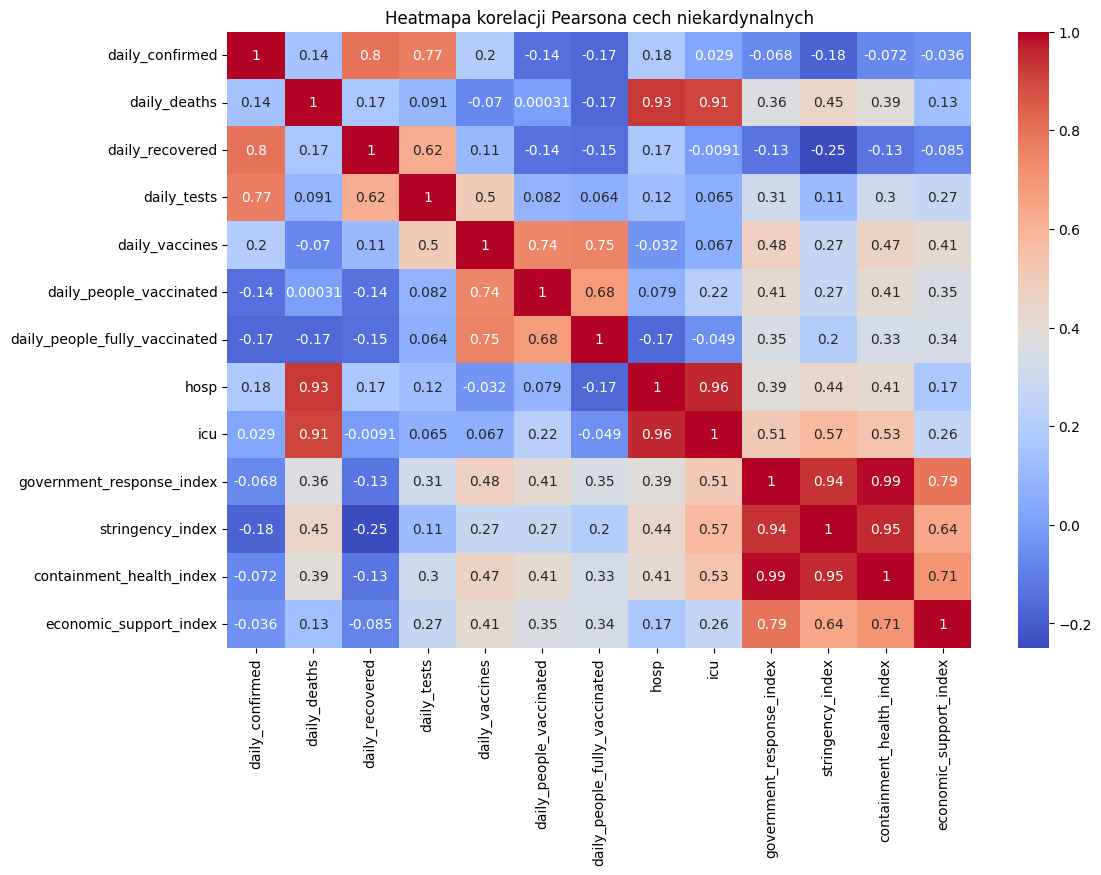

In [ ]:
covid_df_italy_corr = covid_df_italy[['daily_confirmed', 'daily_deaths', 'daily_recovered', 'daily_tests', 'daily_vaccines', 'daily_people_vaccinated', 'daily_people_fully_vaccinated', 'hosp', 'icu',
                                      'government_response_index', 'stringency_index', 'containment_health_index', 'economic_support_index']]

correlation_matrix = covid_df_italy_corr.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Heatmapa korelacji Pearsona cech niekardynalnych')
plt.show()

Przeprowadzono analizę korelacji liniowej Pearsona i zaobserwowano następujące wnioski. Ilość dziennych przypadków zachorowań jest silnie dodatnie skorelowana z dzienną ilością testów oraz z dzienną ilością osób wyzdrowiałych. W przypadku tej drugiej zmiennej to raczej liczba przypadków ma wpływ na liczbę osób wyzdrowiałych, natomiast w przypadku testów można przypuszczać, że im większa liczba testów tym większa liczba zachorowań. W przypadku dziennej ilości zgonów mają one bardzo silną dodatnią korelację z liczbą pacjentów hospitalizowanych oraz liczbą pacjentów na odziale intensywnej terapii w danym dniu. Dane dotyczące wszystkich trzech cech powiązanych z testami są silnie dodatnio skolerowane ze sobą. Cechy liczbowe dotyczące działań politycznych są bardzo silnie skolerowane między sobą, najprawdopodobniej są obliczane na podobnych zmiennych lub zależne od siebie.

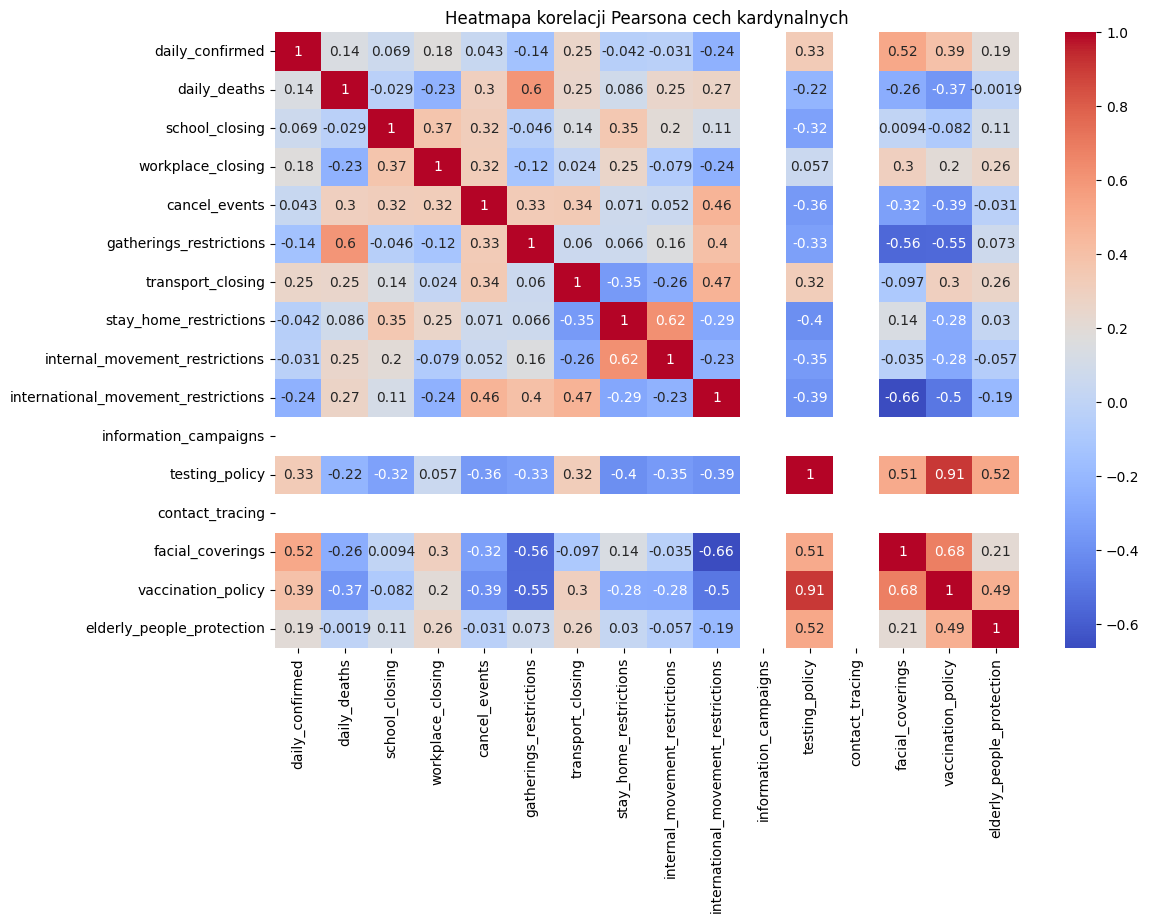

In [ ]:
covid_df_italy_corr2 = covid_df_italy[['daily_confirmed', 'daily_deaths', 'school_closing', 'workplace_closing', 'cancel_events', 'gatherings_restrictions', 'transport_closing', 'stay_home_restrictions',
                                       'internal_movement_restrictions', 'international_movement_restrictions', 'information_campaigns', 'testing_policy', 'contact_tracing', 'facial_coverings', 'vaccination_policy',
                                       'elderly_people_protection']]

correlation_matrix2 = covid_df_italy_corr2.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix2, annot=True, cmap='coolwarm')
plt.title('Heatmapa korelacji Pearsona cech kardynalnych')
plt.show()

In [ ]:
print(covid_df_italy['information_campaigns'].unique())
print(covid_df_italy['contact_tracing'].unique())

covid_df_italy = covid_df_italy.drop(columns=['information_campaigns', 'contact_tracing'])

[2.]
[2.]


Cechy `information_campaigns` oraz `contact_tracing` przyjmują stałe wartości, więc stwierdzono że można je usunąć, ponieważ nie wniosą nic do modelu.

In [ ]:
print(covid_df_italy['school_closing'].value_counts())
print(covid_df_italy['workplace_closing'].value_counts())
print(covid_df_italy['cancel_events'].value_counts())
print(covid_df_italy['gatherings_restrictions'].value_counts())
print(covid_df_italy['transport_closing'].value_counts())
print(covid_df_italy['stay_home_restrictions'].value_counts())
print(covid_df_italy['internal_movement_restrictions'].value_counts())
print(covid_df_italy['international_movement_restrictions'].value_counts())
print(covid_df_italy['testing_policy'].value_counts())
print(covid_df_italy['facial_coverings'].value_counts())
print(covid_df_italy['vaccination_policy'].value_counts())
print(covid_df_italy['elderly_people_protection'].value_counts())

school_closing
 2.0    308
 1.0    243
 3.0    189
 0.0    122
-2.0     93
-3.0     87
Name: count, dtype: int64
workplace_closing
 2.0    695
-3.0    176
 3.0    138
 1.0     33
Name: count, dtype: int64
cancel_events
 2.0    686
 0.0    245
-2.0     88
 1.0     23
Name: count, dtype: int64
gatherings_restrictions
 4.0    310
 0.0    303
 1.0    205
 2.0    126
-4.0     41
-2.0     40
 3.0     17
Name: count, dtype: int64
transport_closing
 0.0    433
 1.0    336
 2.0    264
-1.0      9
Name: count, dtype: int64
stay_home_restrictions
-2.0    521
 0.0    234
 2.0    195
 1.0     92
Name: count, dtype: int64
internal_movement_restrictions
-2.0    498
 0.0    320
 2.0    170
 1.0     47
-1.0      7
Name: count, dtype: int64
international_movement_restrictions
3.0    736
0.0    210
2.0     92
1.0      4
Name: count, dtype: int64
testing_policy
3.0    724
2.0    316
1.0      2
Name: count, dtype: int64
facial_coverings
-4.0    450
 2.0    370
-3.0    134
 3.0     48
 0.0     40
Name: coun

In [ ]:
covid_df_italy['school_closing'] = covid_df_italy['school_closing'].replace({-2: 1.5, -3: 2.5})
covid_df_italy['workplace_closing'] = covid_df_italy['workplace_closing'].replace({-3: 2.5})
covid_df_italy['cancel_events'] = covid_df_italy['cancel_events'].replace({-2: 1.5})
covid_df_italy['gatherings_restrictions'] = covid_df_italy['gatherings_restrictions'].replace({-2: 1.5, -4: 3.5})
covid_df_italy['transport_closing'] = covid_df_italy['transport_closing'].replace({-1: 0.5})
covid_df_italy['stay_home_restrictions'] = covid_df_italy['stay_home_restrictions'].replace({-2: 1.5})
covid_df_italy['internal_movement_restrictions'] = covid_df_italy['internal_movement_restrictions'].replace({-2: 1.5, -1: 0.5})
covid_df_italy['facial_coverings'] = covid_df_italy['facial_coverings'].replace({-4: 3.5, -3: 2.5})
covid_df_italy['elderly_people_protection'] = covid_df_italy['elderly_people_protection'].replace({-3: 2.5})

Dokonano zmiany ujemnych wartości cech kardynalnych na wartości dodatnie o wartości o pół mniejszą niż wartość bezwzględna wcześniejszej wartości. Wartości ujemne reprezentowały wolę polityków u władzy, lecz nie koniecznie stan faktyczny przyjęto, więc że restrykcję poziom niżej są oficjalnie wprowadzone, dlatego dodano do nich pół aby zaznaczyć, że cięższę restrykcję mogą być planowane.

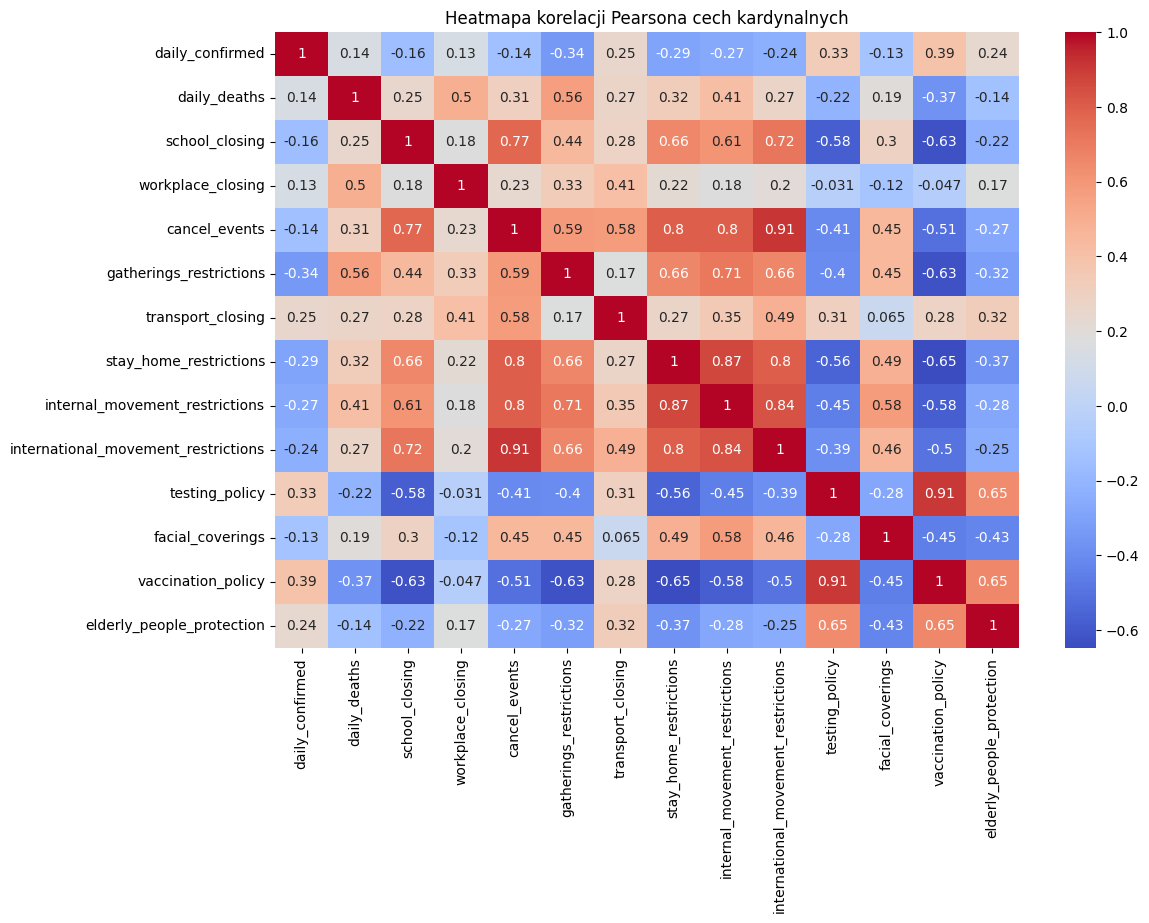

In [ ]:
covid_df_italy_corr2 = covid_df_italy[['daily_confirmed', 'daily_deaths', 'school_closing', 'workplace_closing', 'cancel_events', 'gatherings_restrictions', 'transport_closing', 'stay_home_restrictions',
                                       'internal_movement_restrictions', 'international_movement_restrictions', 'testing_policy', 'facial_coverings', 'vaccination_policy',
                                       'elderly_people_protection']]

correlation_matrix2 = covid_df_italy_corr2.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix2, annot=True, cmap='coolwarm')
plt.title('Heatmapa korelacji Pearsona cech kardynalnych')
plt.show()


W przypadku korelacji cech kardynalnych z liczbą zachorowań oraz liczbą zgonów nie zaobserowowano wniosków wnoszących wartościową informację. Umiarkowana korelacja jest pomiędzy zamykaniem miejsc pracy i restrykcjami dotyczącymi spotykania się z ilościa zgonów na covid co raczej nie jest porządanym efektem. Do tego zauważono słabą ujemną korelację pomiędzy restrykcjami dotyczącymi spotykania się, restrykcjami dotyczącymi zostawania w domu, restrykcjami dotyczącymi przemieszczania z ilościa zachorowań, co oznacza że gdy te restrykcje są wprowadzane to ilość zachorowań może maleć.

                   Zmienna           MSE        R2
0                     hosp   5629.158924  0.866676
1                      icu   7327.371244  0.826454
2  gatherings_restrictions  26526.070626  0.371741
3        workplace_closing  35018.414782  0.170603
4           testing_policy  40587.186456  0.038709
5       vaccination_policy  35845.333368  0.151018


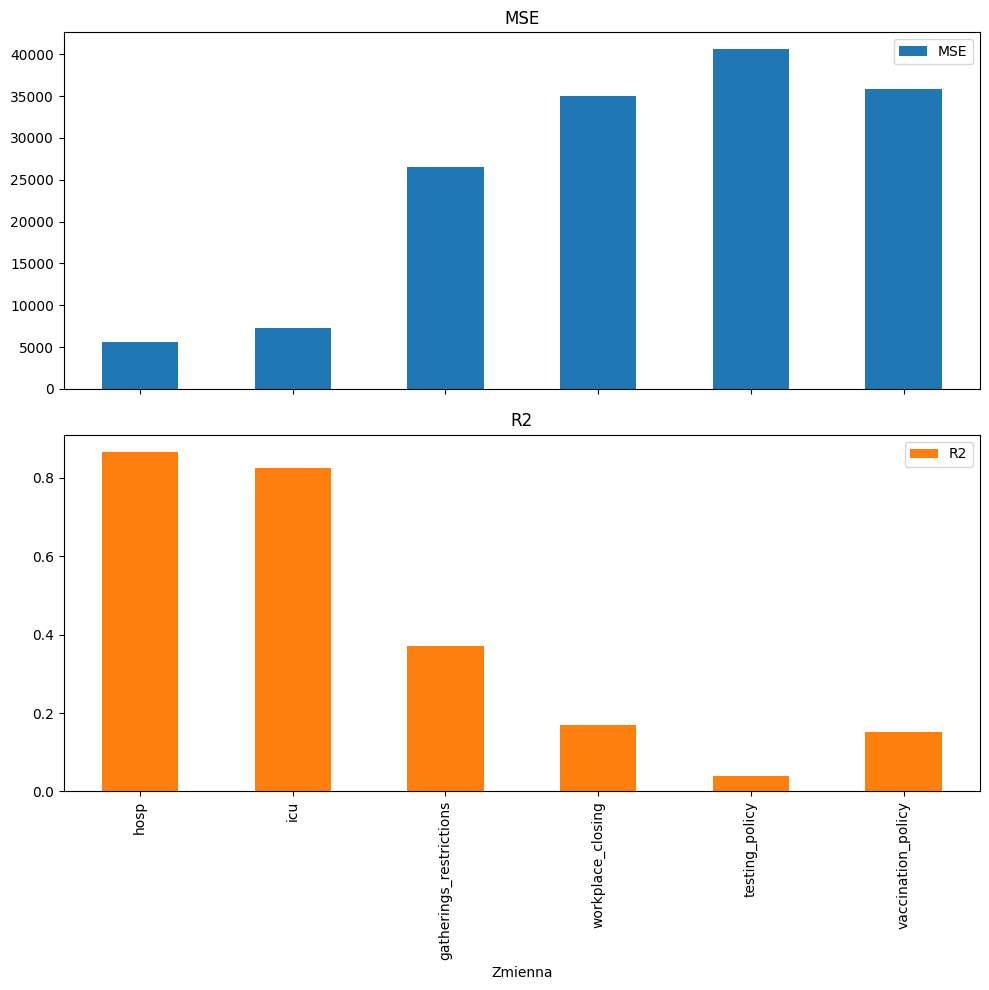

In [ ]:
features_deaths = ['hosp', 'icu', 'gatherings_restrictions', 'workplace_closing', 'testing_policy', 'vaccination_policy']

features_deaths_res = []

for feature in features_deaths:
    X = covid_df_italy[feature].values.reshape(-1, 1)
    y = covid_df_italy['daily_deaths']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    features_deaths_res.append({'Zmienna': feature, 'MSE': mse, 'R2': r2})


results_death_df = pd.DataFrame(features_deaths_res)
print(results_death_df)

results_death_df.set_index('Zmienna').plot(kind='bar', subplots=True, layout=(2, 1), figsize=(10, 10))
plt.tight_layout()
plt.show()

Dla modelu regresji liniowej dla przewidywania liczby zgonów wybrano zmienne `hosp`, `icu`, gdyż miały bardzo silną korelację liniową ze zmienną `daily_deaths` oraz zmianne `gatherings_restrictions`, `workplace_closing` (miały one umiarkowaną korelację dodatnią ze zmienną `daily_deaths` i stwierdzono, że ciekwae będzie sprawdzenie tego mimo że korelacja nie sugeruje zależności jakiej oczekiwano, ponieważ wzorst tych zmiennyc powinien powodować spadek liczby zgonów)  i `testing_policy`, `vaccination_policy`. Najmniejszy błąd średniokwadratowy (MSE) miała zmienna `hosp`, czyli liczba pacjęntów hospitalizowanych, zaraz po niej była zmienna `icu` ozanaczjąca liczbę pacjentów na odziale intensywnej terapii. Pozostałe zmienne miały wysoką wartość błędu średniokwadratowego. Jeżeli chodzi o wartość wspołczynnika r2, najwyższą wartość osiągnięta została dla zmiennej `hosp`, a zaraz po niej `icu`. Pozostałe zmienne miały dużo gorrsze wartości. Oznacza to że dla zmiennej `hosp` model najlepiej dopasowuje się do danych.

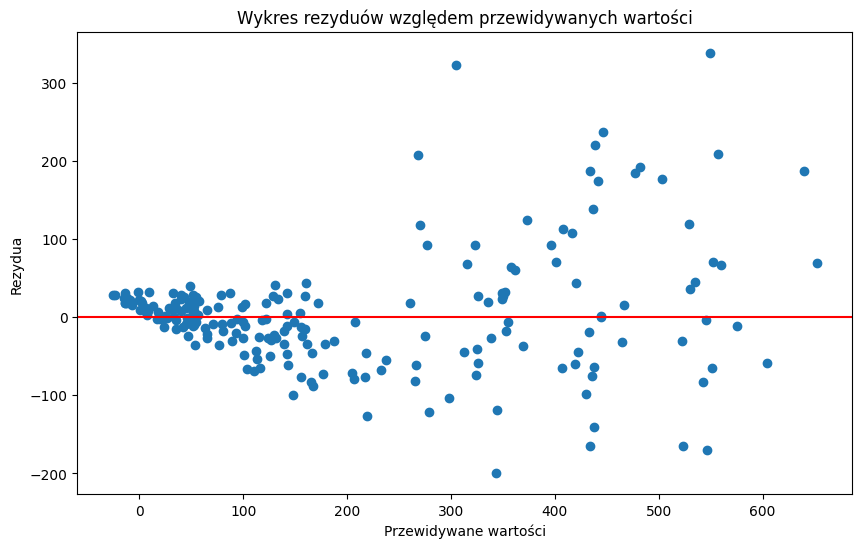

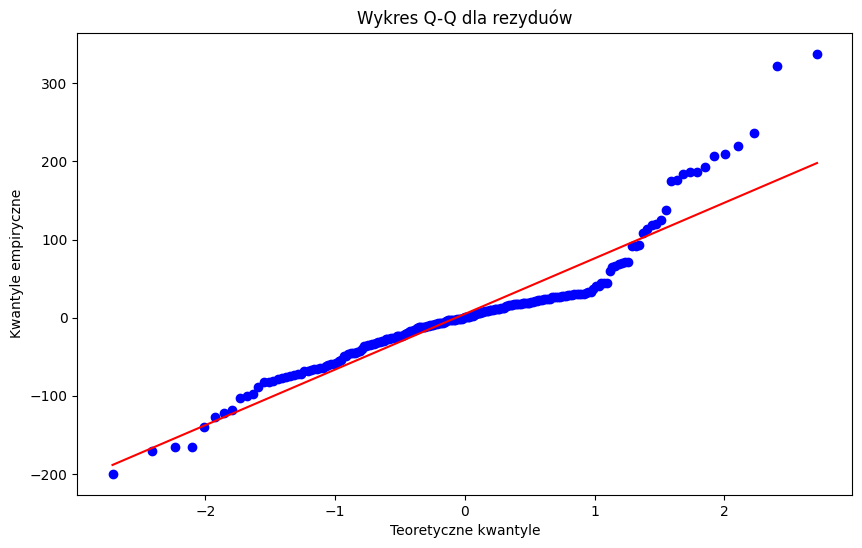

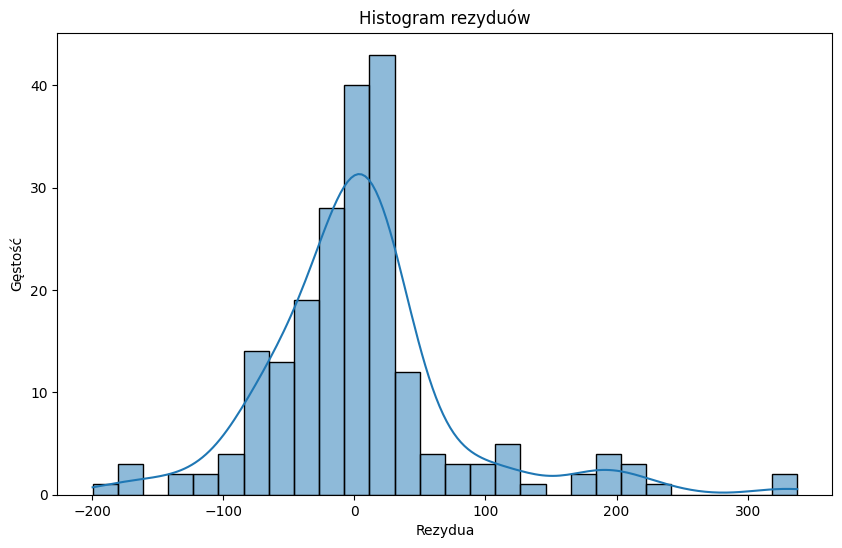

Shapiro-Wilk test: statystyka=0.8888800144195557, p-value=2.6240815076405966e-11
Regresja jednoliniowa - MSE: 5629.158924252663, R2: 0.8666756778629743


In [ ]:
feature = 'hosp'

X_single = covid_df_italy[feature].values.reshape(-1, 1)
y = covid_df_italy['daily_deaths']

X_train_single, X_test_single, y_train, y_test = train_test_split(X_single, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_single_scaled = scaler.fit_transform(X_train_single)
X_test_single_scaled = scaler.transform(X_test_single)

model_single = LinearRegression()
model_single.fit(X_train_single_scaled, y_train)

y_pred_single = model_single.predict(X_test_single_scaled)

mse_single = mean_squared_error(y_test, y_pred_single)
r2_single = r2_score(y_test, y_pred_single)

residuals = y_test - y_pred_single

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_single, residuals)
plt.axhline(0, color='red', linestyle='-')
plt.xlabel('Przewidywane wartości')
plt.ylabel('Rezydua')
plt.title('Wykres rezyduów względem przewidywanych wartości')
plt.show()

plt.figure(figsize=(10, 6))
sp.stats.probplot(residuals, dist='norm', plot=plt)
plt.title('Wykres Q-Q dla rezyduów')
plt.xlabel('Teoretyczne kwantyle')
plt.ylabel('Kwantyle empiryczne')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Histogram rezyduów')
plt.xlabel('Rezydua')
plt.ylabel('Gęstość')
plt.show()

shapiro_test = sp.stats.shapiro(residuals)
print(f'Shapiro-Wilk test: statystyka={shapiro_test.statistic}, p-value={shapiro_test.pvalue}')

print(f'Regresja jednoliniowa - MSE: {mse_single}, R2: {r2_single}')

Zwizualizowano rezydua na wykresie względem przewidywanych wartości punkty na nim są równomiernie rozproszone co może sugerować, że model jest dobrze dopasowany i założenie liniowości jest spełnione. Zwizualizowano także kwantyle rozkładu rezyduów modelu z kwantylami teoretycznego rozkładu normalnego. Punkty są relatywnie blisko prostej jednak na końcach znacząco się oddalają. Na histogramie rozkładu rezyduów widać, że jego kształt odbiega od rozkładu normalnego. Przeprowadzono także test Shapiro-Wilka, gdzie wartości statystyki: 0.8888800144195557 oraz p-value 2.6240815076405966e-11 sugerują, że rezydua tego modelu nie są normalnie rozproszone co oznacza, że rozkład rezyduów nie spełnia założenia dla regresji liniowej.

In [ ]:
X_multi = covid_df_italy[features_deaths]

X_train_multi, X_test_multi, y_train, y_test = train_test_split(X_multi, y, test_size=0.2, random_state=42)

X_train_multi_scaled = scaler.fit_transform(X_train_multi)
X_test_multi_scaled = scaler.transform(X_test_multi)

model_multi = LinearRegression()
model_multi.fit(X_train_multi_scaled, y_train)

y_pred_multi = model_multi.predict(X_test_multi_scaled)

mse_multi = mean_squared_error(y_test, y_pred_multi)
r2_multi = r2_score(y_test, y_pred_multi)

print(f'Regresja wielowymiarowa - MSE: {mse_multi}, R2: {r2_multi}')

Regresja wielowymiarowa - MSE: 5302.036342853482, R2: 0.8744234421395976


Wykonano model regresji wielowymiarowej na bazie zmiennych użytych wcześniej w jednoparametrowej regresji liniowej. Porównując metryki MSE i R2 stwierdzono, że lepiej wypadł model wielowymiarowy, jednak poprawa ta nie jest bardzo duża.

daily_recovered
daily_tests
gatherings_restrictions
stay_home_restrictions
internal_movement_restrictions
international_movement_restrictions
                               Zmienna           MSE        R2
0                      daily_recovered  4.760514e+08  0.607703
1                          daily_tests  4.045224e+08  0.666647
2              gatherings_restrictions  1.082872e+09  0.107642
3               stay_home_restrictions  1.151782e+09  0.050857
4       internal_movement_restrictions  1.171170e+09  0.034879
5  international_movement_restrictions  1.197016e+09  0.013580


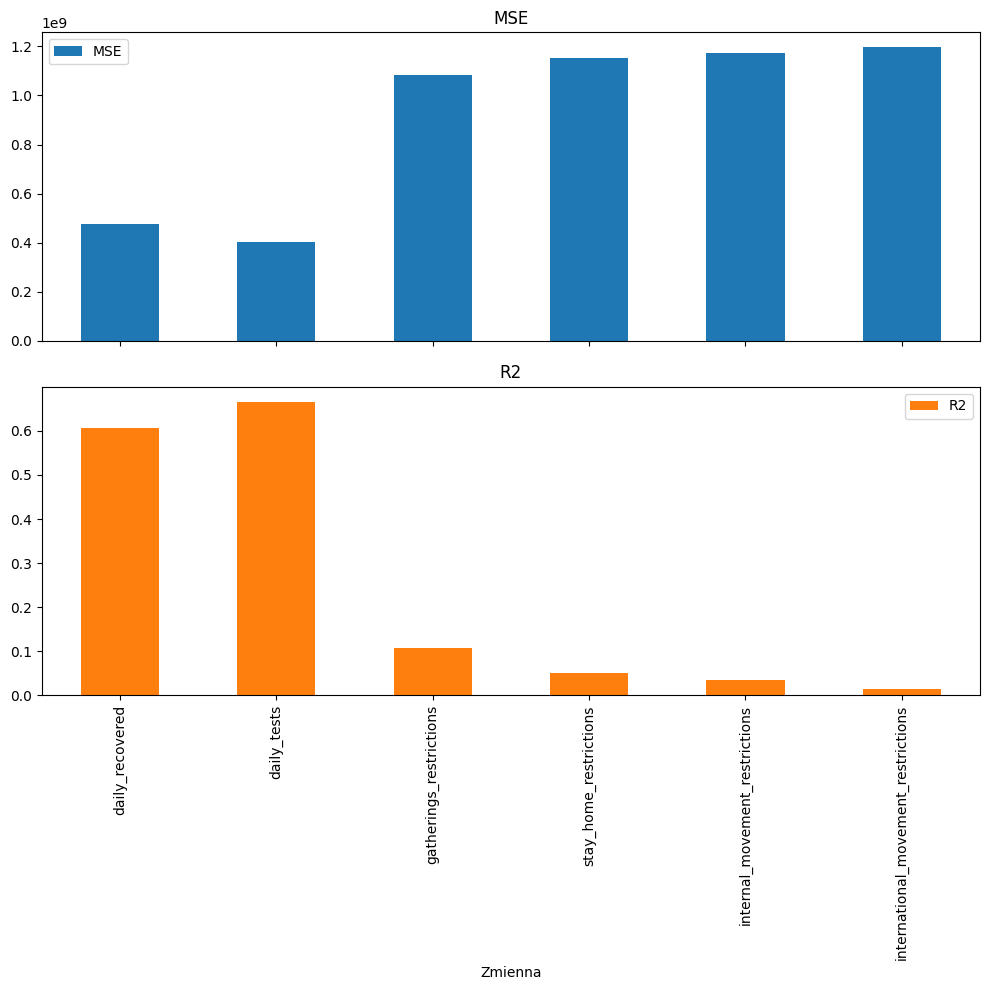

In [ ]:
features_confirmed = ['daily_recovered', 'daily_tests', 'gatherings_restrictions', 'stay_home_restrictions', 'internal_movement_restrictions', 'international_movement_restrictions']

features_confirmed_res = []

for feature in features_confirmed:

  print(feature)
  X = covid_df_italy[feature].values.reshape(-1, 1)
  y = covid_df_italy['daily_confirmed']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  scaler = StandardScaler()

  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)

  model = LinearRegression()
  model.fit(X_train_scaled, y_train)

  y_pred = model.predict(X_test_scaled)

  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  features_confirmed_res.append({'Zmienna': feature, 'MSE': mse, 'R2': r2})


results_confirmed_df = pd.DataFrame(features_confirmed_res)
print(results_confirmed_df)

results_confirmed_df.set_index('Zmienna').plot(kind='bar', subplots=True, layout=(2, 1), figsize=(10, 10))
plt.tight_layout()
plt.show()

Dla modelu regresji liniowej dla przewidywania liczby zgonów wybrano zmienne `daily_recovered` i `daily_tests`, gdyż miały bardzo silną korelację liniową ze zmienną `daily_confirmed` oraz zmienne `gatherings_restrictions`, `stay_home_restrictions`, `internal_movement_restrictions`, `international_movement_restrictions`, ponieważ miały one umiarkowaną ujemną korelację ze zmienną `daily_confirmed` co było pożądane ze względu na to, że gdy restrykcję resną zakażenia powinny maleć i na odwrót. Najmniejszy błąd średniokwadratowy (MSE) miała zmienna `daily_tests`, czyli liczba przeprowadzonych testów, zaraz po niej była zmienna `daily_recovered` ozanaczjąca liczbę pacjentów wyzdorwiałych. Pozostałe zmienne miały wysoką wartość błędu średniokwadratowego. Jeżeli chodzi o wartość wspołczynnika r2, najwyższą wartość osiągnięta została dla zmiennej `daily_tests`, a zaraz po niej `daily_recovered`. Pozostałe zmienne miały dużo gorsze wartości. Oznacza to że dla zmiennej `daily_tests` model najlepiej dopasowuje się do danych. Jednak jak wiadomo logiczne będzie, że gdy więcej osób zostanie przetestowanych tym więcej będzie zarażonych.

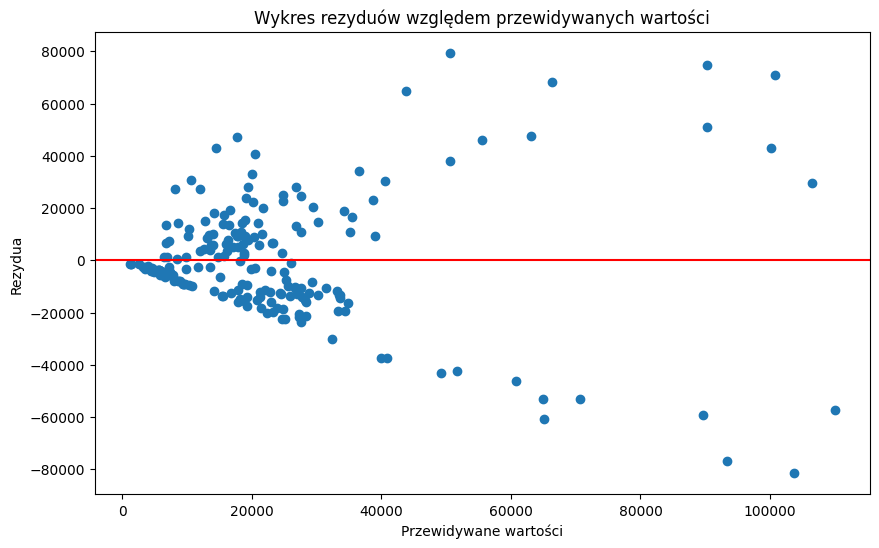

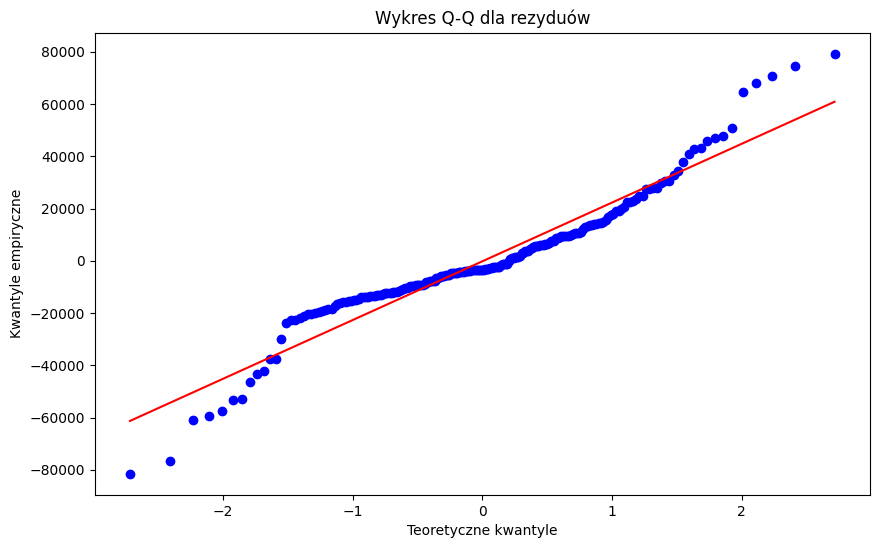

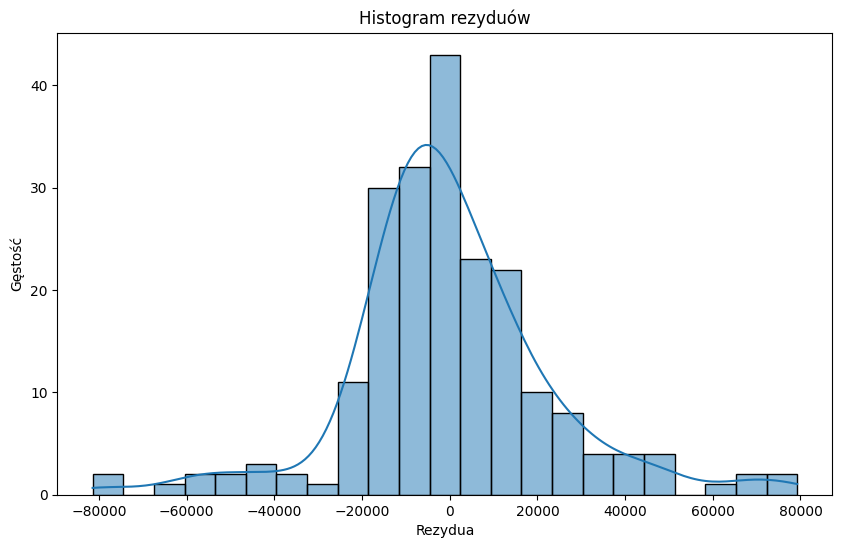

Shapiro-Wilk test: statystyka=0.9323372840881348, p-value=2.9834893666702555e-08
Regresja jednoliniowa - MSE: 533516507.40475726, R2: 0.4253530982031897


In [ ]:
feature = 'daily_tests'

X_single = covid_df_italy[feature].values.reshape(-1, 1)
y = covid_df_italy['daily_recovered']

X_train_single, X_test_single, y_train, y_test = train_test_split(X_single, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_single_scaled = scaler.fit_transform(X_train_single)
X_test_single_scaled = scaler.transform(X_test_single)

model_single = LinearRegression()
model_single.fit(X_train_single_scaled, y_train)

y_pred_single = model_single.predict(X_test_single_scaled)

mse_single = mean_squared_error(y_test, y_pred_single)
r2_single = r2_score(y_test, y_pred_single)

residuals = y_test - y_pred_single

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_single, residuals)
plt.axhline(0, color='red', linestyle='-')
plt.xlabel('Przewidywane wartości')
plt.ylabel('Rezydua')
plt.title('Wykres rezyduów względem przewidywanych wartości')
plt.show()

plt.figure(figsize=(10, 6))
sp.stats.probplot(residuals, dist='norm', plot=plt)
plt.title('Wykres Q-Q dla rezyduów')
plt.xlabel('Teoretyczne kwantyle')
plt.ylabel('Kwantyle empiryczne')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Histogram rezyduów')
plt.xlabel('Rezydua')
plt.ylabel('Gęstość')
plt.show()

shapiro_test = sp.stats.shapiro(residuals)
print(f'Shapiro-Wilk test: statystyka={shapiro_test.statistic}, p-value={shapiro_test.pvalue}')

print(f'Regresja jednoliniowa - MSE: {mse_single}, R2: {r2_single}')

Tutaj rónież wykonano wykres rezyduów względem przewidywanych wartości, gdzie wartości były rozłożone równomiernie. Jednak ponownie wynik testu Shapiro-Wilk: statystyka: 0.9323372840881348, p-value=2.9834893666702555e-08 sugeruje, że rozkład rezyduów znacznie odbiega od normalności.

In [ ]:
X_multi = covid_df_italy[features_confirmed]

X_train_multi, X_test_multi, y_train, y_test = train_test_split(X_multi, y, test_size=0.2, random_state=42)

X_train_multi_scaled = scaler.fit_transform(X_train_multi)
X_test_multi_scaled = scaler.transform(X_test_multi)

model_multi = LinearRegression()
model_multi.fit(X_train_multi_scaled, y_train)

y_pred_multi = model_multi.predict(X_test_multi_scaled)

mse_multi = mean_squared_error(y_test, y_pred_multi)
r2_multi = r2_score(y_test, y_pred_multi)

print(f'Regresja wielowymiarowa - MSE: {mse_multi}, R2: {r2_multi}')

Regresja wielowymiarowa - MSE: 2.8939448033434154e-22, R2: 1.0


W przypadku danych dotyczących liczby zachorowań wyniki metryk MSE i R2 dla regresji wielowymiarowej jest imponująco dobry co może świadczyć o przetrenowaniu danych. Dla regresji liniowej jednoparametrowej wartości tych metryk nie były za dobre. Przetrenowanie dla regresji wielowymiarowej może oznaczać, że za dużo zmiennych zostało podanych do modelu i jest on zbyt złożony.

In [ ]:
features_deaths += ['daily_confirmed', 'government_response_index', 'stringency_index', 'containment_health_index', 'vaccination_policy',
                    'daily_people_vaccinated', 'daily_people_fully_vaccinated']

X = covid_df_italy[features_deaths]
y = covid_df_italy['daily_deaths']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def plot_real_vs_pred(y_test, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, label='Przewidywane wartości')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Rzeczywiste wartości')
    plt.legend()
    plt.xlabel('Rzeczywiste wartości')
    plt.ylabel('Przewidywane wartości')
    plt.title(f'Rzeczywiste vs. Przewidywane wartości ({model_name})')
    plt.show()

SVR - MSE: 30487.337097875934, R2: 0.2779199153847052


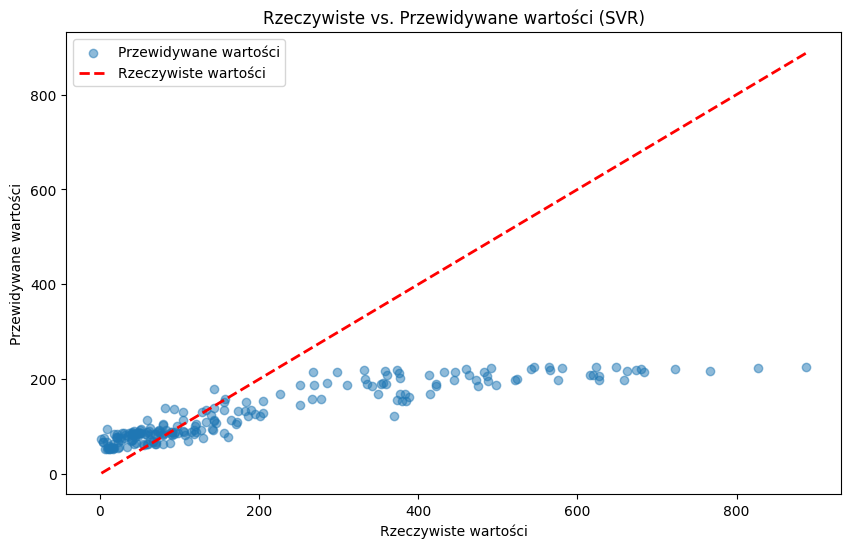

In [ ]:
svr_model = SVR()

svr_model.fit(X_train_scaled, y_train)

y_pred_svr = svr_model.predict(X_test_scaled)

mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print(f'SVR - MSE: {mse_svr}, R2: {r2_svr}')

plot_real_vs_pred(y_test, y_pred_svr, 'SVR')

Drzewa regresyjne - MSE: 5246.808612440192, R2: 0.875731488300596


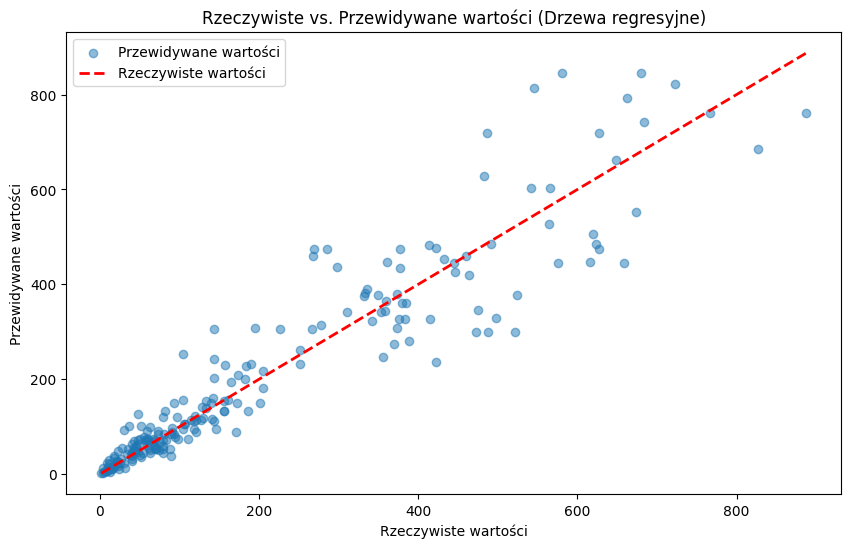

In [ ]:
tree_model = DecisionTreeRegressor(random_state=42)

tree_model.fit(X_train_scaled, y_train)

y_pred_tree = tree_model.predict(X_test_scaled)

mse_tree = mean_squared_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)

print(f'Drzewa regresyjne - MSE: {mse_tree}, R2: {r2_tree}')

plot_real_vs_pred(y_test, y_pred_tree, 'Drzewa regresyjne')

Las losowy regresyjny - MSE: 3472.3781866028708, R2: 0.9177581457262401


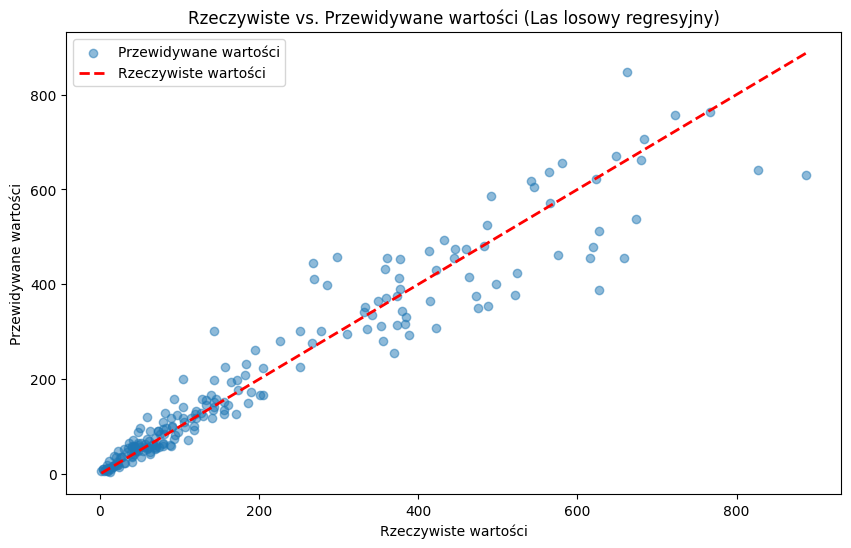

In [ ]:
rf_model = RandomForestRegressor(random_state=42)

rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_scaled)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Las losowy regresyjny - MSE: {mse_rf}, R2: {r2_rf}')

plot_real_vs_pred(y_test, y_pred_rf, 'Las losowy regresyjny')

Dla modeli przewidujących liczbę śmierci porównano algorytmy SVR, drzew regresyjnych i losowego lasu regresyjnego. Jako zmiennych użyto wcześniej używanych do regresji liniowej zmiennych oraz `daily_confirmed` ze względu na możliwy wpływ ilości zachorowań na ilość śmierci, `government_response_index`, `stringency_index` oraz `containment_health_index`, ponieważ zmienne te miały umiarkowaną dodatnią korelację ze zmienne dotyczącą liczby śmierci. Dodano również `vaccination_policy`, `daily_people_vaccinated`, `daily_people_fully_vaccinated` ze względu na możliwy wpływ polityki szczepień oraz ilości osób zaszczepionych na liczbę zgonów. Najlepsze metryki MSE i R2 wykazał model Losowego lasy regresyjnego. Co widoczne jest też na wykresie porównującym wartości rzeczywiste z przewidywanymi. Najgorzej wypadł algorytm SVR, który posiadał bardzo duży błąd średniokwadratowy.

In [ ]:
features_confirmed += ['school_closing', 'workplace_closing', 'cancel_events', 'vaccination_policy', 'transport_closing', 'facial_coverings', 'elderly_people_protection'
                    'daily_people_vaccinated', 'daily_people_fully_vaccinated']

X = covid_df_italy[features_deaths]
y = covid_df_italy['daily_deaths']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


SVR - MSE: 30487.337097875934, R2: 0.2779199153847052


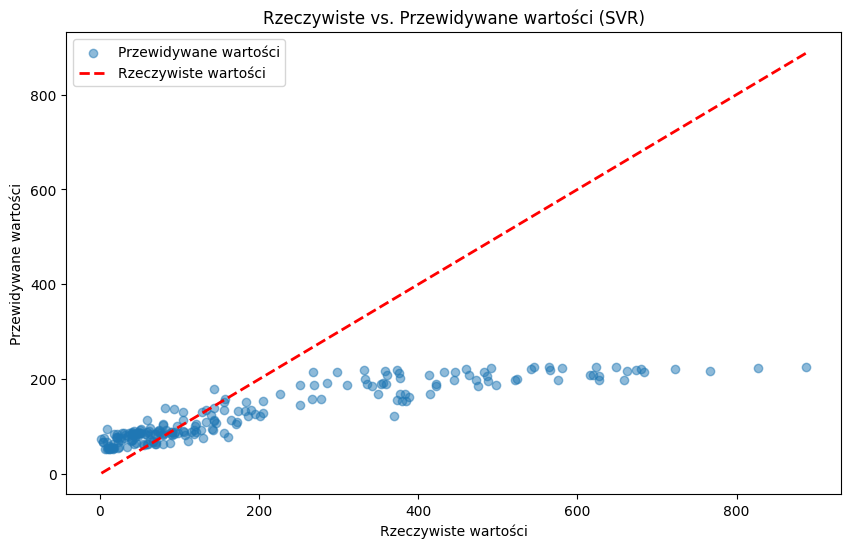

In [ ]:
svr_model = SVR()

svr_model.fit(X_train_scaled, y_train)

y_pred_svr = svr_model.predict(X_test_scaled)

mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print(f'SVR - MSE: {mse_svr}, R2: {r2_svr}')

plot_real_vs_pred(y_test, y_pred_svr, 'SVR')

Drzewa regresyjne - MSE: 5246.808612440192, R2: 0.875731488300596


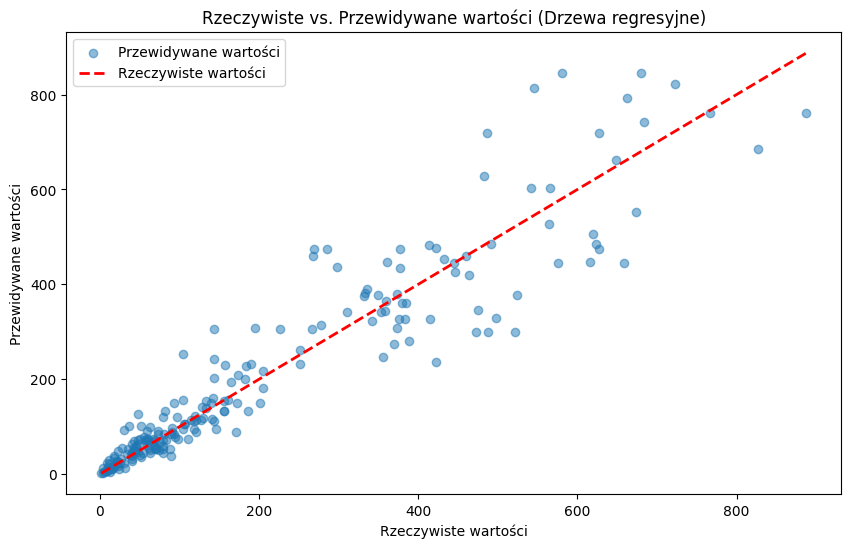

In [ ]:
tree_model = DecisionTreeRegressor(random_state=42)

tree_model.fit(X_train_scaled, y_train)

y_pred_tree = tree_model.predict(X_test_scaled)

mse_tree = mean_squared_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)

print(f'Drzewa regresyjne - MSE: {mse_tree}, R2: {r2_tree}')

plot_real_vs_pred(y_test, y_pred_tree, 'Drzewa regresyjne')

Las losowy regresyjny - MSE: 3472.3781866028708, R2: 0.9177581457262401


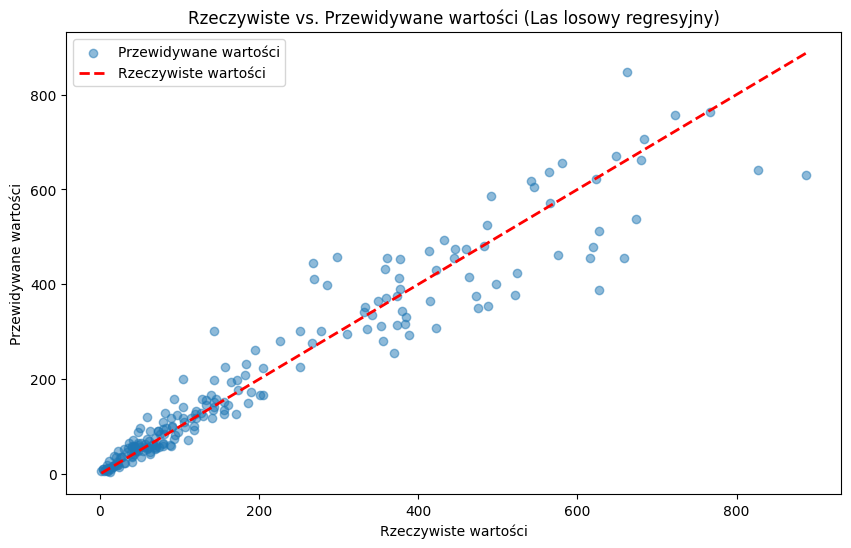

In [ ]:
rf_model = RandomForestRegressor(random_state=42)

rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_scaled)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Las losowy regresyjny - MSE: {mse_rf}, R2: {r2_rf}')

plot_real_vs_pred(y_test, y_pred_rf, 'Las losowy regresyjny')

Dla tych samych algorytmów utworzono modele przewidujące liczbę zachorowań. Poza wcześniejszymi zmiennymi używanymi do przewidywania liczby zachorowań użyto dodatkowo zmiennych odnoszących się do obowiązujących restrykcji, gdyż stwierdzono, że mogą one wnieść cenną informację do modelu ze względu, że wprowadzane restrykcję miały na celu zmniejszenie liczby zachorowań. Dodano również zmienne dotyczące polityki szczepień i liczby szczepień, ponieważ szczepienia również były prowadzone w celu zmniejszenia liczby zachorowań. Ponownie najlepsze wyniki osiągnął algorytm Losowego lasu regresyjnego i ponownie najgorszy okazał się algorytm SVR.

Stwierdzono, że algorytmy oparte na regresji wydają się być dobrym podejściem do zadanego problemu, czyli próby przewidzenia liczby zgonów i zachorowań na Covid-19, ale nie idealnym. Przede wszystkim dane te nie są liniowe i są bardzo złożone, czego modele regresyjne mogą nie wychwycić. Po drugie dane bardzo zmieniają się w czasie (z doświadczenia wiadomo, że pandemia miała inny przebieg w okresie letnim niż w okresie zimowym). Poza tym w tym przypadku dane mają często związek z tym co działo się kilka dni wcześniej a brak jest szerszych wzorców. Modele regresji nieliniowej, jak chociażby Losowy las regresyjny poradziły sobie lepiej od modeli liniowych. Uznano, że dobrą alternatywą mogą być modele oparte o algorytmu szeregów czasowych ze względu na charakter danych. Stwierdzono, że w celu polepszenia wyników można zmienić model, chociażby jak podano wcześniej na oparty o algorytmy szeregów czasowych, można równiez przeprowadzić tuning hyperparametrów. Przydatne też mogłoby się okazać rozpatrywanie danych ze względu na okres pandemii, ponieważ jak zauważono na wykresach liniowych liczby zachorowań i zgonów parametry te miały okresy nagłego wzrostu oraz okresy stagnacji. Globalne rozpatrywanie tego problemu wydaje się niezwykle problematyczne, ze względu na bardzo dużą złożoność zagadnienia. Każdy kraj prowadził inną politykę dotyczącą obostrzeń, nie wszystkie kraje raportowały dane w sposób rzetelny, jaki i poszczególne kraje raportowały dane w różniący się sposób. Te zależności powodują, że skonstruowanie dobrego modelu który globalnie przewidywał by liczbę zgonów lub liczbę zachorowań mogłoby się okazać bardzo trudne.

Spostrzeżenia dotyczące zgonów i zachorowań:
Jak już wcześniej wspomniano zarówno liczba zgonów jak i liczba zachorowań miała przebieg nieregularny i zależała od okresu pandemii. Zobserwowano, że liczba zgonów jest silnie liniowo zależna od liczby pacjentów hospitalizowanych oraz na odziałach intensywnej terapii. Liczba zachorowań jest za to silnie zależna od liczby przeprowadzonych testów.